# Different Optimizer - learning rate = 0.01

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

### Data loading

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Hyperparameters

In [3]:
ops = ['Adam', 'RMS', 'AdaGD', 'GD']
l_r = 0.01 # Learning rate
epoch = 2000
batch_size = 128

In [4]:
n_inputs = 28 # MNIST data input, img shape = (28, 28), view the graph row by row
n_steps = 28 # Time steps - shift 28 times
n_hidden_units = 128 # Neuron no. in hidden layer
n_classes = 10 # 0~9

### Placeholder - input and output data holders

In [5]:
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_classes])

### Create static initial parameters

In [6]:
# create static initial parameters
w_h1 = tf.random_normal([n_inputs, n_hidden_units])
w_out = tf.random_normal([n_hidden_units, n_classes])
b_h1 = tf.random_normal([n_hidden_units, ])
b_out = tf.random_normal([n_classes, ])

In [7]:
def get_static_w_b():
    # create static initial parameters
    w_h1 = tf.random_normal([n_inputs, n_hidden_units])
    w_out = tf.random_normal([n_hidden_units, n_classes])
    b_h1 = tf.random_normal([n_hidden_units, ])
    b_out = tf.random_normal([n_classes, ])
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        w_h1, w_out, b_h1, b_out = sess.run([w_h1, w_out, b_h1, b_out])
    weights = dict()
    biases = dict()
    # Create weights and biases for diff ops
    for op in ops:
        weights[op] = {
        # (28 inputs, 128 neurons)
        'h1':tf.Variable(tf.constant(w_h1)),
        # (128 inputs, 10 neurons)
        'out':tf.Variable(tf.constant(w_out))
        }
        biases[op] = {
        # (128 neurons, )
        'h1':tf.Variable(tf.constant(b_h1)),
        # (10 neurons, )
        'out':tf.Variable(tf.constant(b_out))
        }
    return weights, biases

### RNN structure

In [8]:
def RNN(X, weights, biases, op='Adam'):
    # h1
    X = tf.reshape(X, [-1, n_inputs])
    X_in = tf.matmul(X, weights[op]['h1']) + biases[op]['h1']
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])
    
    with tf.variable_scope(op):
        # rnn cell
        rnn_cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden_units,
                                                              forget_bias=1.0,
                                                              state_is_tuple=True)
        _init_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)
        # outputs: the rnns outputs
        outputs, states = tf.nn.dynamic_rnn(cell=rnn_cell,
                                            inputs=X_in,
                                            initial_state=_init_state,
                                            time_major=False)
    
    # output layer
    outputs = tf.unstack(tf.transpose(outputs, [1, 0, 2]))
    results = tf.matmul(outputs[-1], weights[op]['out']) + biases[op]['out']
    
    return results

In [9]:
def get_pred(x, weights, biases):
    pred = dict()
    for op in ops:
        pred[op] = RNN(x, weights, biases, op=op)
    return pred

def get_loss(pred, y):
    loss = dict()
    for op in ops:
        loss[op] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred[op], labels=y))
    return loss

def get_accu(pred, y):
    accu = dict()
    for op in ops:
        accu[op] = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred[op], 1), tf.argmax(y, 1)), tf.float32))
    return accu

def get_op(loss, l_r):
    train_op = dict()
    train_op['Adam'] = tf.train.AdamOptimizer(l_r).minimize(loss['Adam'])
    train_op['RMS'] = tf.train.RMSPropOptimizer(l_r).minimize(loss['RMS'])
    train_op['AdaGD'] = tf.train.AdagradOptimizer(l_r).minimize(loss['AdaGD'])
    train_op['GD'] = tf.train.GradientDescentOptimizer(l_r).minimize(loss['GD'])
    return train_op

In [10]:
ex_time = 0

### Experiments

In [11]:
import time
loss_val_train = dict()
loss_val_test = dict()
accu_val_train = dict()
accu_val_test = dict()
time_span = dict()
for op in ops:
    loss_val_train[op] = list()
    loss_val_test[op] = list()
    accu_val_train[op] = list()
    accu_val_test[op] = list()
    time_span[op] = list()
for ex in range(10):
    ex_time += 1
    with tf.variable_scope('ex'+str(ex_time)):
        weights, biases = get_static_w_b()
        pred = get_pred(x, weights, biases)
        loss = get_loss(pred, y)
        accu = get_accu(pred, y)
        train_op = get_op(loss, l_r)
    init2 = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init2)
        startTime = time.time()
        for epo in range(epoch):
            # read training data
            batch_xs_train, batch_ys_train = mnist.train.next_batch(batch_size)
            batch_xs_train = batch_xs_train.reshape([batch_size, n_steps, n_inputs])
            # read testing data
            batch_xs_test, batch_ys_test = mnist.test.next_batch(batch_size)
            batch_xs_test = batch_xs_test.reshape([batch_size, n_steps, n_inputs])
            # Training and testing
            for op in ops:
                t1 = time.time()
                sess.run([train_op[op]], feed_dict={
                    x:batch_xs_train,
                    y:batch_ys_train
                })
                t2 = time.time()
                # save time-span
                time_span[op].append(t2-t1)
                # find loss and accuracy for training set
                l, a = sess.run([loss[op], accu[op]], feed_dict={
                    x:batch_xs_train,
                    y:batch_ys_train
                })
                loss_val_train[op].append(l)
                accu_val_train[op].append(a)
                # find loss and accuracy for testing set
                l, a = sess.run([loss[op], accu[op]], feed_dict={
                    x:batch_xs_test,
                    y:batch_ys_test
                })
                loss_val_test[op].append(l)
                accu_val_test[op].append(a)
            
            # print result each 100 epochs
            if (epo+1)%100 == 0:
                print('Epoch', epo+1,
                      ', Losses:', '%2.4f, %2.4f, %2.4f, %2.4f'\
                      % (loss_val_train['Adam'][-1], loss_val_train['RMS'][-1],
                         loss_val_train['AdaGD'][-1], loss_val_train['GD'][-1]),
                      ', Accuracies:', '%2.4f, %2.4f, %2.4f, %2.4f'\
                      % (accu_val_train['Adam'][-1], accu_val_train['RMS'][-1],
                         accu_val_train['AdaGD'][-1], accu_val_train['GD'][-1]))
        endTime = time.time()
        timespan = endTime - startTime
        print('--------------------EX'+str(ex+1), 'done.', 'Spent', '%2.2f' % timespan, 'secs.')
        #writer = tf.summary.FileWriter("logs/", sess.graph)
# tensorboard: terminal >> tensorboard --logdir='logs/'

#save the result
np.save('./diffOP_data/loss_val_train_diffOP_lr0.01', loss_val_train)
np.save('./diffOP_data/loss_val_test_diffOP_lr0.01', loss_val_test)
np.save('./diffOP_data/accu_val_train_diffOP_lr0.01', accu_val_train)
np.save('./diffOP_data/accu_val_test_diffOP_lr0.01', accu_val_test)
np.save('./diffOP_data/time_span_diffOP_lr0.01', time_span)

Epoch 100 , Losses: 1.9283, 1.7720, 1.1402, 1.4617 , Accuracies: 0.3359, 0.3516, 0.6484, 0.4531
Epoch 200 , Losses: 1.3421, 0.5571, 0.6916, 0.9294 , Accuracies: 0.5156, 0.7812, 0.7812, 0.6328
Epoch 300 , Losses: 0.9159, 0.2256, 0.2356, 0.4722 , Accuracies: 0.7266, 0.9219, 0.9375, 0.8516
Epoch 400 , Losses: 0.8440, 0.1554, 0.3257, 0.4834 , Accuracies: 0.7344, 0.9609, 0.8594, 0.8125
Epoch 500 , Losses: 0.5992, 0.1497, 0.3768, 0.5150 , Accuracies: 0.7812, 0.9688, 0.8906, 0.8359
Epoch 600 , Losses: 0.5079, 0.1257, 0.2374, 0.4671 , Accuracies: 0.7969, 0.9453, 0.9062, 0.8516
Epoch 700 , Losses: 0.5375, 0.1259, 0.3589, 0.8141 , Accuracies: 0.7969, 0.9766, 0.8906, 0.7656
Epoch 800 , Losses: 0.4566, 0.0632, 0.1649, 0.3580 , Accuracies: 0.8672, 0.9766, 0.9453, 0.8906
Epoch 900 , Losses: 0.1973, 0.0291, 0.0972, 0.3150 , Accuracies: 0.9453, 1.0000, 0.9844, 0.8906
Epoch 1000 , Losses: 0.3019, 0.0527, 0.1654, 0.3207 , Accuracies: 0.8906, 0.9922, 0.9688, 0.9141
Epoch 1100 , Losses: 0.3387, 0.0931, 0.

Epoch 400 , Losses: 0.9362, 0.2464, 0.4542, 0.6045 , Accuracies: 0.6875, 0.9141, 0.8750, 0.7500
Epoch 500 , Losses: 0.8356, 0.1360, 0.4541, 0.5680 , Accuracies: 0.7656, 0.9688, 0.8359, 0.8516
Epoch 600 , Losses: 0.7280, 0.0597, 0.2652, 0.3204 , Accuracies: 0.7266, 0.9766, 0.9219, 0.9297
Epoch 700 , Losses: 0.7238, 0.0623, 0.2697, 0.4250 , Accuracies: 0.7266, 0.9844, 0.9219, 0.8516
Epoch 800 , Losses: 0.5352, 0.1376, 0.2234, 0.4342 , Accuracies: 0.8125, 0.9609, 0.9531, 0.8281
Epoch 900 , Losses: 0.5917, 0.0547, 0.3114, 0.4169 , Accuracies: 0.7969, 0.9922, 0.8672, 0.8359
Epoch 1000 , Losses: 0.6185, 0.0613, 0.4206, 0.4723 , Accuracies: 0.8047, 0.9844, 0.8906, 0.8750
Epoch 1100 , Losses: 0.5945, 0.1165, 0.2632, 0.4005 , Accuracies: 0.8125, 0.9688, 0.8984, 0.8516
Epoch 1200 , Losses: 0.2240, 0.0443, 0.1333, 0.3136 , Accuracies: 0.9375, 0.9922, 0.9688, 0.8750
Epoch 1300 , Losses: 0.3522, 0.0402, 0.1958, 0.2856 , Accuracies: 0.8984, 0.9922, 0.9219, 0.9141
Epoch 1400 , Losses: 0.2927, 0.0144,

Epoch 700 , Losses: 0.3044, 0.0767, 0.2640, 0.4165 , Accuracies: 0.9297, 0.9766, 0.8906, 0.8672
Epoch 800 , Losses: 0.2555, 0.0654, 0.2085, 0.3381 , Accuracies: 0.9219, 0.9844, 0.9531, 0.8828
Epoch 900 , Losses: 0.2255, 0.0692, 0.2197, 0.3745 , Accuracies: 0.9375, 0.9844, 0.9453, 0.8516
Epoch 1000 , Losses: 0.2206, 0.0512, 0.1558, 0.2500 , Accuracies: 0.9375, 0.9922, 0.9609, 0.9297
Epoch 1100 , Losses: 0.1526, 0.0347, 0.1895, 0.2976 , Accuracies: 0.9688, 1.0000, 0.9453, 0.8828
Epoch 1200 , Losses: 0.2471, 0.0476, 0.1776, 0.3085 , Accuracies: 0.9219, 0.9922, 0.9531, 0.9141
Epoch 1300 , Losses: 0.1466, 0.0190, 0.1322, 0.2723 , Accuracies: 0.9531, 0.9922, 0.9609, 0.9219
Epoch 1400 , Losses: 0.0686, 0.0154, 0.0781, 0.1336 , Accuracies: 0.9844, 1.0000, 0.9688, 0.9766
Epoch 1500 , Losses: 0.1507, 0.0792, 0.1610, 0.2711 , Accuracies: 0.9531, 0.9844, 0.9453, 0.8906
Epoch 1600 , Losses: 0.0931, 0.0120, 0.1106, 0.1672 , Accuracies: 0.9766, 1.0000, 0.9688, 0.9375
Epoch 1700 , Losses: 0.1402, 0.02

### Result

In [13]:
epoch = 2000
ops = ['Adam', 'RMS', 'AdaGD', 'GD']
import numpy as np
loss_val_train = np.load('./diffOP_data/loss_val_train_diffOP_lr0.01.npy')
loss_val_test = np.load('./diffOP_data/loss_val_test_diffOP_lr0.01.npy')
accu_val_train = np.load('./diffOP_data/accu_val_train_diffOP_lr0.01.npy')
accu_val_test = np.load('./diffOP_data/accu_val_test_diffOP_lr0.01.npy')
time_span = np.load('./diffOP_data/time_span_diffOP_lr0.01.npy')

loss_val_train = loss_val_train[None][0]
loss_val_test = loss_val_test[None][0]
accu_val_train = accu_val_train[None][0]
accu_val_test = accu_val_test[None][0]
time_span = time_span[None][0]

In [14]:
# result ploting
import matplotlib.pyplot as plt

### Epoch - Training loss & accuracy

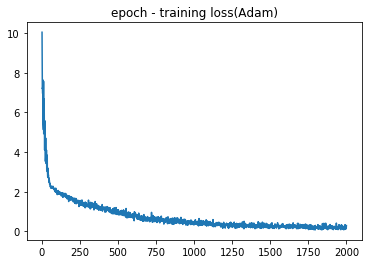

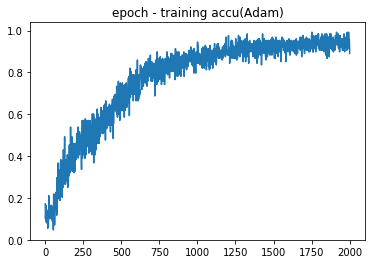

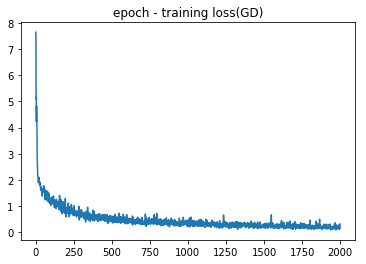

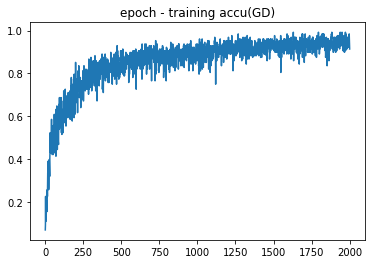

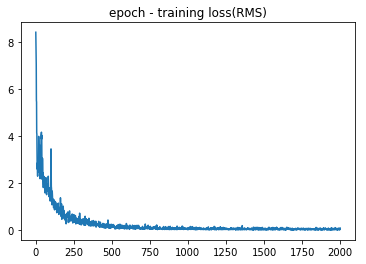

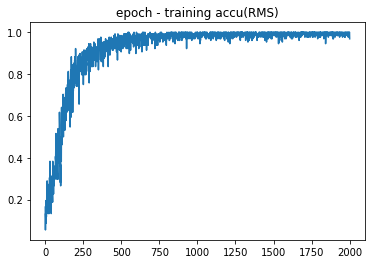

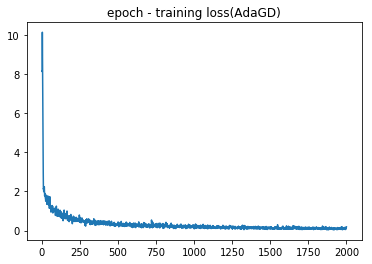

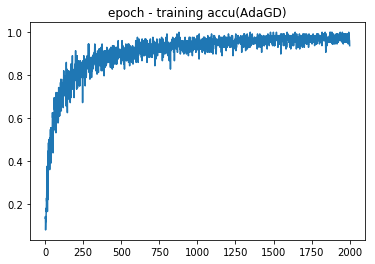

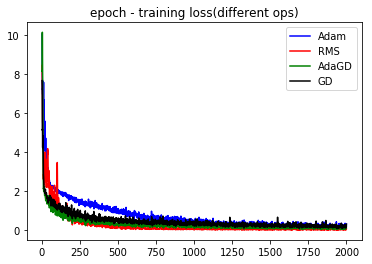

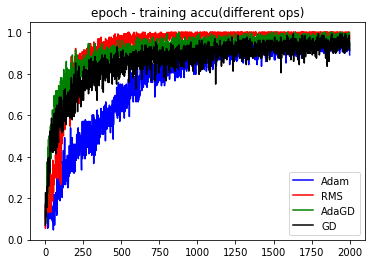

In [17]:
# epoch v.s.training loss
i = 0
for op, losses in loss_val_train.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - training loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(accu_val_train[op][-epoch:])+1), accu_val_train[op][-epoch:])
    plt.title('epoch - training accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(1, len(loss_val_train['Adam'][-epoch:])+1), loss_val_train['Adam'][-epoch:], 'b',
         range(1, len(loss_val_train['RMS'][-epoch:])+1), loss_val_train['RMS'][-epoch:], 'r',
         range(1, len(loss_val_train['AdaGD'][-epoch:])+1), loss_val_train['AdaGD'][-epoch:], 'g',
         range(1, len(loss_val_train['GD'][-epoch:])+1), loss_val_train['GD'][-epoch:], 'k')
plt.title('epoch - training loss(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=1)
plt.show()

plt.plot(range(1, len(accu_val_train['Adam'][-epoch:])+1), accu_val_train['Adam'][-epoch:], 'b',
         range(1, len(accu_val_train['RMS'][-epoch:])+1), accu_val_train['RMS'][-epoch:], 'r',
         range(1, len(accu_val_train['AdaGD'][-epoch:])+1), accu_val_train['AdaGD'][-epoch:], 'g',
         range(1, len(accu_val_train['GD'][-epoch:])+1), accu_val_train['GD'][-epoch:], 'k')
plt.title('epoch - training accu(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=4)

plt.show()

### Epoch - Testing loss & accuracy

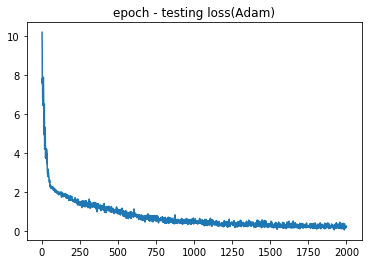

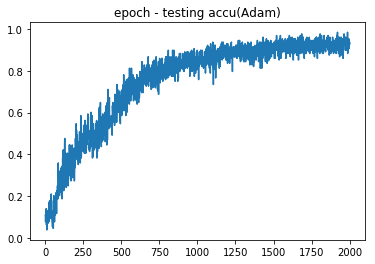

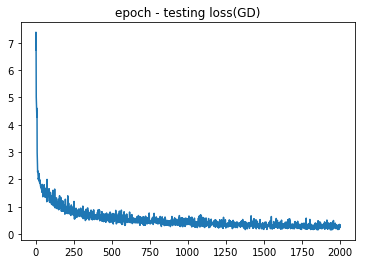

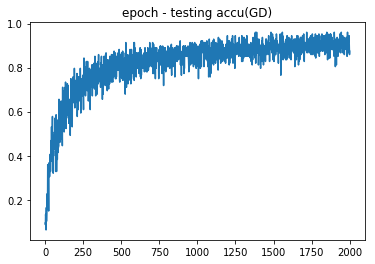

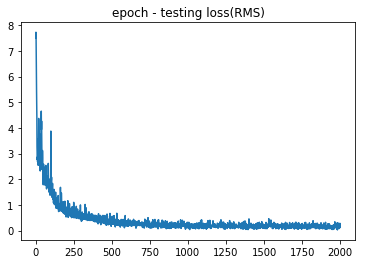

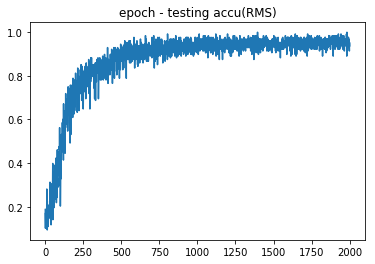

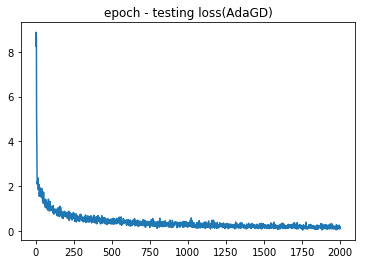

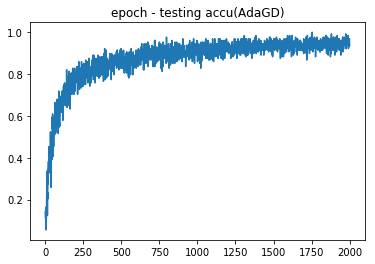

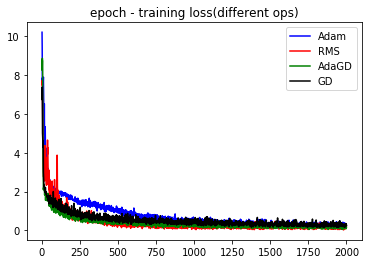

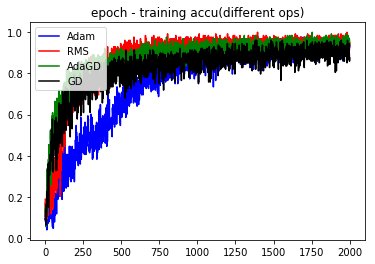

In [18]:
# epoch v.s. testing loss
i = 0
for op, losses in loss_val_test.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - testing loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(accu_val_test[op][-epoch:])+1), accu_val_test[op][-epoch:])
    plt.title('epoch - testing accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(1, len(loss_val_test['Adam'][-epoch:])+1), loss_val_test['Adam'][-epoch:], 'b',
         range(1, len(loss_val_test['RMS'][-epoch:])+1), loss_val_test['RMS'][-epoch:], 'r',
         range(1, len(loss_val_test['AdaGD'][-epoch:])+1), loss_val_test['AdaGD'][-epoch:], 'g',
         range(1, len(loss_val_test['GD'][-epoch:])+1), loss_val_test['GD'][-epoch:], 'k')
plt.title('epoch - training loss(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=1)
plt.show()

plt.plot(range(1, len(accu_val_test['Adam'][-epoch:])+1), accu_val_test['Adam'][-epoch:], 'b',
         range(1, len(accu_val_test['RMS'][-epoch:])+1), accu_val_test['RMS'][-epoch:], 'r',
         range(1, len(accu_val_test['AdaGD'][-epoch:])+1), accu_val_test['AdaGD'][-epoch:], 'g',
         range(1, len(accu_val_test['GD'][-epoch:])+1), accu_val_test['GD'][-epoch:], 'k')
plt.title('epoch - training accu(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=2)

plt.show()

In [19]:
# smooth the line
len(loss_val_train['Adam']) # 782
last_point = 0
loss_val_train_ = dict()
loss_val_test_ = dict()
accu_val_train_ = dict()
accu_val_test_ = dict()
for op in ops:
    # training loss
    loss_val_train_[op] = list()
    loss_list = loss_val_train[op][-epoch:]
    for i in range(int(len(loss_list)/10)):
        loss_val_train_[op].append(np.mean(loss_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(loss_list)%10 != 0:
        loss_val_train_[op].append(np.mean(loss_list[last_point:]))
    # testing loss
    loss_val_test_[op] = list()
    loss_list = loss_val_test[op][-epoch:]
    for i in range(int(len(loss_list)/10)):
        loss_val_test_[op].append(np.mean(loss_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(loss_list)%10 != 0:
        loss_val_test_[op].append(np.mean(loss_list[last_point:]))
    # training accu
    accu_val_train_[op] = list()
    accu_list = accu_val_train[op][-epoch:]
    for i in range(int(len(accu_list)/10)):
        accu_val_train_[op].append(np.mean(accu_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(accu_list)%10 != 0:
        accu_val_train_[op].append(np.mean(accu_list[last_point:]))
    # testing accu
    accu_val_test_[op] = list()
    accu_list = accu_val_test[op][-epoch:]
    for i in range(int(len(accu_list)/10)):
        accu_val_test_[op].append(np.mean(accu_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(accu_list)%10 != 0:
        accu_val_test_[op].append(np.mean(accu_list[last_point:]))

### Epoch - Training loss & accuracy (smooth)

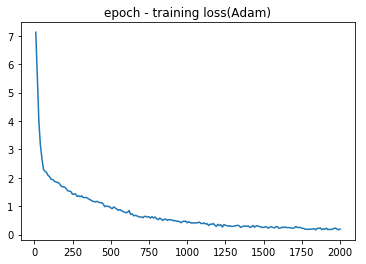

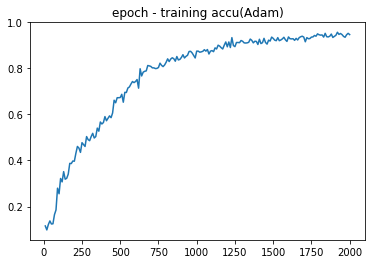

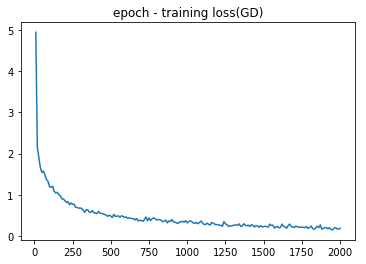

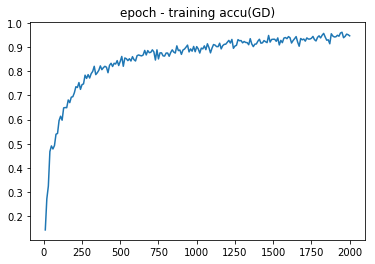

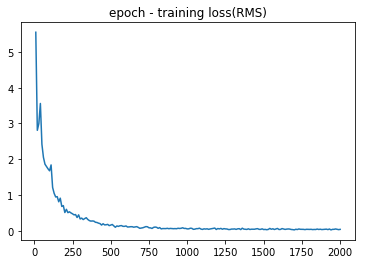

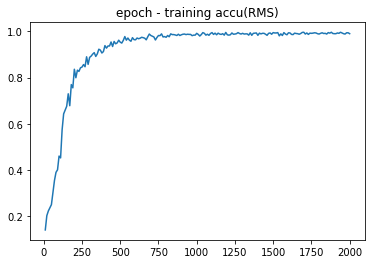

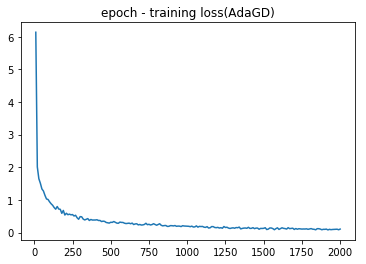

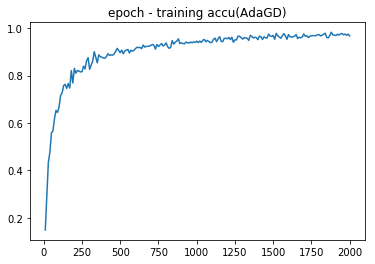

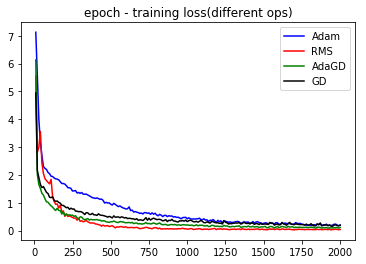

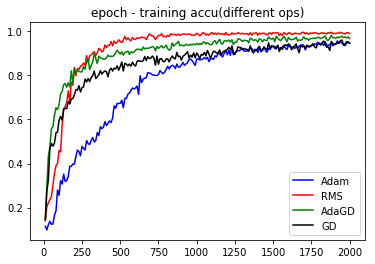

In [20]:
# epoch v.s.training loss & accu - smooth
i = 0
for op, losses in loss_val_train_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(losses[-epoch:])*10+10, 10), losses[-epoch:])
    plt.title('epoch - training loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(accu_val_train_[op][-epoch:])*10+10, 10), accu_val_train_[op][-epoch:])
    plt.title('epoch - training accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(10, len(loss_val_train_['Adam'][-epoch:])*10+10, 10), loss_val_train_['Adam'][-epoch:], 'b',
         range(10, len(loss_val_train_['RMS'][-epoch:])*10+10, 10), loss_val_train_['RMS'][-epoch:], 'r',
         range(10, len(loss_val_train_['AdaGD'][-epoch:])*10+10, 10), loss_val_train_['AdaGD'][-epoch:], 'g',
         range(10, len(loss_val_train_['GD'][-epoch:])*10+10, 10), loss_val_train_['GD'][-epoch:], 'k')
plt.title('epoch - training loss(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=1)
plt.savefig('./diffOP_data/epoch_loss_train_0.01.png')
plt.show()

plt.plot(range(10, len(accu_val_train_['Adam'][-epoch:])*10+10, 10), accu_val_train_['Adam'][-epoch:], 'b',
         range(10, len(accu_val_train_['RMS'][-epoch:])*10+10, 10), accu_val_train_['RMS'][-epoch:], 'r',
         range(10, len(accu_val_train_['AdaGD'][-epoch:])*10+10, 10), accu_val_train_['AdaGD'][-epoch:], 'g',
         range(10, len(accu_val_train_['GD'][-epoch:])*10+10, 10), accu_val_train_['GD'][-epoch:], 'k')
plt.title('epoch - training accu(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=4)
plt.savefig('./diffOP_data/epoch_accu_train_0.01.png')
plt.show()

### Epoch - Testing loss & accuracy (smooth)

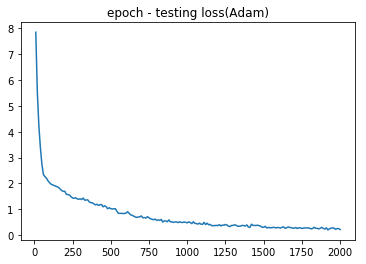

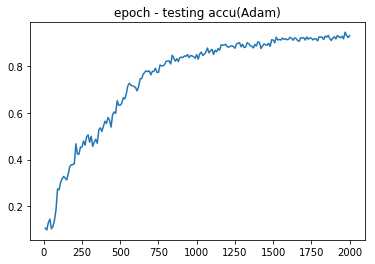

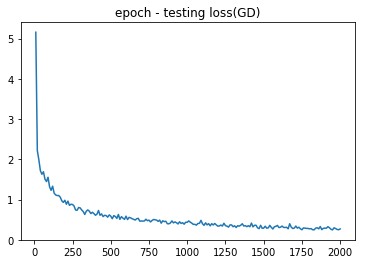

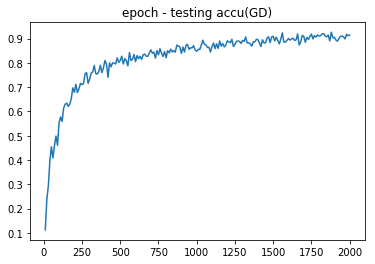

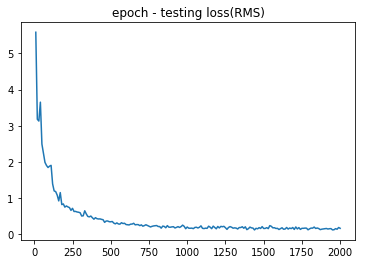

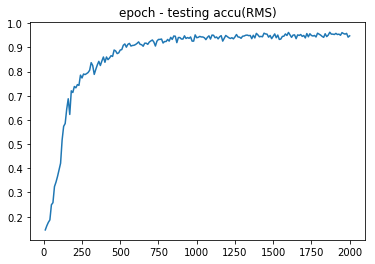

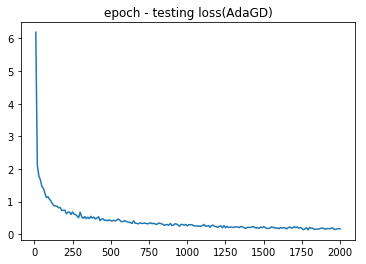

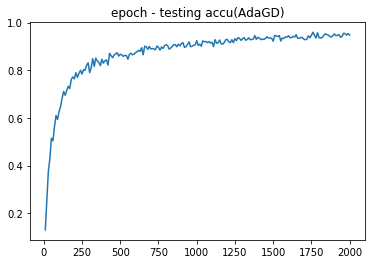

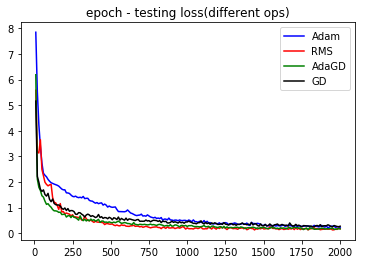

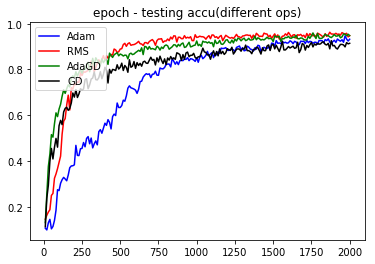

In [21]:
# epoch v.s.testing loss - smooth
i = 0
for op, losses in loss_val_test_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(losses[-epoch:])*10+10, 10), losses[-epoch:])
    plt.title('epoch - testing loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(accu_val_test_[op][-epoch:])*10+10, 10), accu_val_test_[op][-epoch:])
    plt.title('epoch - testing accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(10, len(loss_val_test_['Adam'][-epoch:])*10+10, 10), loss_val_test_['Adam'][-epoch:], 'b',
         range(10, len(loss_val_test_['RMS'][-epoch:])*10+10, 10), loss_val_test_['RMS'][-epoch:], 'r',
         range(10, len(loss_val_test_['AdaGD'][-epoch:])*10+10, 10), loss_val_test_['AdaGD'][-epoch:], 'g',
         range(10, len(loss_val_test_['GD'][-epoch:])*10+10, 10), loss_val_test_['GD'][-epoch:], 'k')
plt.title('epoch - testing loss(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=1)
plt.savefig('./diffOP_data/epoch_loss_test_0.01.png')
plt.show()

plt.plot(range(10, len(accu_val_test_['Adam'][-epoch:])*10+10, 10), accu_val_test_['Adam'][-epoch:], 'b',
         range(10, len(accu_val_test_['RMS'][-epoch:])*10+10, 10), accu_val_test_['RMS'][-epoch:], 'r',
         range(10, len(accu_val_test_['AdaGD'][-epoch:])*10+10, 10), accu_val_test_['AdaGD'][-epoch:], 'g',
         range(10, len(accu_val_test_['GD'][-epoch:])*10+10, 10), accu_val_test_['GD'][-epoch:], 'k')
plt.title('epoch - testing accu(different ops)')
plt.legend(['Adam', 'RMS', 'AdaGD', 'GD'], loc=2)
plt.savefig('./diffOP_data/epoch_accu_test_0.01.png')
plt.show()

# Statistics Inference : ANOVA and T-test

In [22]:
from scipy import stats as st
# ANOVA:  f_val, p_val = st.f_oneway(data_array1, data_array2, ...)

In [23]:
# data extract
loss_means_train = dict()
for op, losses in loss_val_train.items():
    mean = list()
    ex_time = len(losses)/epoch
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_train[op] = mean

loss_means_test = dict()
for op, losses in loss_val_test.items():
    mean = list()
    ex_time = len(losses)/epoch
    
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_test[op] = mean

accu_means_train = dict()
for op, accus in accu_val_train.items():
    mean = list()
    ex_time = len(accus)/epoch
    
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(accus[(ex+1)*epoch-100:(ex+1)*epoch]))
    accu_means_train[op] = mean
    
accu_means_test = dict()
for op, accus in accu_val_test.items():
    mean = list()
    ex_time = len(accus)/epoch
    
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(accus[(ex+1)*epoch-100:(ex+1)*epoch]))
    accu_means_test[op] = mean
    

    

Adam 10.0
GD 10.0
RMS 10.0
AdaGD 10.0
Adam 10.0
GD 10.0
RMS 10.0
AdaGD 10.0
Adam 10.0
GD 10.0
RMS 10.0
AdaGD 10.0
Adam 10.0
GD 10.0
RMS 10.0
AdaGD 10.0


In [24]:
print(np.mean(time_span['Adam']), np.mean(time_span['RMS']), 
      np.mean(time_span['AdaGD']), np.mean(time_span['GD']))


0.0109322892189 0.0108740993381 0.0108065057158 0.01084493258


In [25]:
np.save('./diffOP_data/loss_means_train_diffOP_lr0.01', loss_means_train)
np.save('./diffOP_data/loss_means_test_diffOP_lr0.01', loss_means_test)
np.save('./diffOP_data/accu_means_train_diffOP_lr0.01', accu_means_train)
np.save('./diffOP_data/accu_means_test_diffOP_lr0.01', accu_means_test)
loss_means_train, loss_means_test, accu_means_train, accu_means_test

({'AdaGD': [0.079233713,
   0.12045193,
   0.10816496,
   0.0994078,
   0.10925224,
   0.088906221,
   0.095689833,
   0.10717044,
   0.10681397,
   0.098930761],
  'Adam': [0.16614714,
   0.15654807,
   0.16748819,
   0.23808929,
   0.21062799,
   0.13742954,
   0.18901064,
   0.17874876,
   0.1273827,
   0.19924299],
  'GD': [0.19947654,
   0.2061972,
   0.19318773,
   0.18897486,
   0.22964928,
   0.19022381,
   0.20546775,
   0.214471,
   0.20981313,
   0.18246201],
  'RMS': [0.028629942,
   0.036255047,
   0.042187948,
   0.032527793,
   0.036929782,
   0.030025996,
   0.032678992,
   0.028558824,
   0.031497508,
   0.036986757]},
 {'AdaGD': [0.15243134,
   0.17966393,
   0.16552088,
   0.15933509,
   0.18293199,
   0.16853467,
   0.16393471,
   0.16182721,
   0.17114635,
   0.17042889],
  'Adam': [0.21632868,
   0.20106466,
   0.19885184,
   0.27952695,
   0.25688061,
   0.17355685,
   0.23356801,
   0.23007779,
   0.17225,
   0.24897724],
  'GD': [0.26978457,
   0.27591357,
   0

### training loss

In [26]:
# ANOVA - find that whether ops effect the training loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(loss_means_train['Adam'],
                           loss_means_train['RMS'],
                           loss_means_train['AdaGD'],
                           loss_means_train['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')

# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(loss_means_train[op])
    StD[op] = np.std(loss_means_train[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')

# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(loss_means_train)-1):
    t_val, p_val = st.ttest_ind(loss_means_train[ops_sort[len(loss_means_train)-1-i]],
                                loss_means_train[ops_sort[len(loss_means_train)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(loss_means_train)-1-i] + ' > ' + ops_sort[len(loss_means_train)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(loss_means_train)-1-i] + ' = ' + ops_sort[len(loss_means_train)-2-i])
        compare_flag.append('=')
    print('')

F value: 157.384494232 , P value: 9.53728401072e-21
They are NOT identical at all.

         OP      mean     StD    
         RMS    0.0336   0.0042
       AdaGD    0.1014   0.0111
        Adam    0.1771   0.0319
          GD    0.2020   0.0134

t value: 2.16327587213 , P value: 0.0512870759543
GD = Adam

t value: 6.72867903986 , P value: 3.05711794905e-05
Adam > AdaGD

t value: 17.2099049729 , P value: 1.46614499726e-09
AdaGD > RMS



In [27]:
# result
print('Loss::',
      ops_sort[3], compare_flag[0], 
      ops_sort[2], compare_flag[1], 
      ops_sort[1], compare_flag[2],
      ops_sort[0])

Loss:: GD = Adam > AdaGD > RMS


### training accuracy

In [28]:
# ANOVA - find that whether ops effect the training accuracy or not
alpha = 0.05
f_val, p_val = st.f_oneway(accu_means_train['Adam'],
                           accu_means_train['RMS'],
                           accu_means_train['AdaGD'],
                           accu_means_train['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(accu_means_train[op])
    StD[op] = np.std(accu_means_train[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')
# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(accu_means_train)-1):
    t_val, p_val = st.ttest_ind(accu_means_train[ops_sort[len(accu_means_train)-1-i]],
                                accu_means_train[ops_sort[len(accu_means_train)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(accu_means_train)-1-i] + ' > ' + ops_sort[len(accu_means_train)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(accu_means_train)-1-i] + ' = ' + ops_sort[len(accu_means_train)-2-i])
        compare_flag.append('=')
    print('')

F value: 174.743169892 , P value: 1.65269562083e-21
They are NOT identical at all.

         OP      mean     StD    
          GD    0.9387   0.0052
        Adam    0.9496   0.0089
       AdaGD    0.9726   0.0034
         RMS    0.9925   0.0013

t value: 16.4808541994 , P value: 2.41686587581e-09
RMS > AdaGD

t value: 7.26713684502 , P value: 1.20971049773e-05
AdaGD > Adam

t value: 3.15602277214 , P value: 0.00675199704153
Adam > GD



In [29]:
# result
print('Accuracy::',
      ops_sort[3], compare_flag[0], 
      ops_sort[2], compare_flag[1], 
      ops_sort[1], compare_flag[2],
      ops_sort[0])

Accuracy:: RMS > AdaGD > Adam > GD


### testing loss

In [30]:
# ANOVA - find that whether ops effect the testing loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(loss_means_test['Adam'],
                           loss_means_test['RMS'],
                           loss_means_test['AdaGD'],
                           loss_means_test['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(loss_means_test[op])
    StD[op] = np.std(loss_means_test[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')
# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(loss_means_test)-1):
    t_val, p_val = st.ttest_ind(loss_means_test[ops_sort[len(loss_means_test)-1-i]],
                                loss_means_test[ops_sort[len(loss_means_test)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(loss_means_test)-1-i] + ' > ' + ops_sort[len(loss_means_test)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(loss_means_test)-1-i] + ' = ' + ops_sort[len(loss_means_test)-2-i])
        compare_flag.append('=')
    print('')

F value: 97.203164731 , P value: 2.52423796612e-17
They are NOT identical at all.

         OP      mean     StD    
         RMS    0.1456   0.0087
       AdaGD    0.1676   0.0087
        Adam    0.2211   0.0336
          GD    0.2820   0.0097

t value: 5.22874242976 , P value: 0.000328275513199
GD > Adam

t value: 4.63134402921 , P value: 0.000887900155676
Adam > AdaGD

t value: 5.36744951667 , P value: 4.22157230792e-05
AdaGD > RMS



In [31]:
# result
print('Loss::',
      ops_sort[3], compare_flag[0], 
      ops_sort[2], compare_flag[1], 
      ops_sort[1], compare_flag[2],
      ops_sort[0])

Loss:: GD > Adam > AdaGD > RMS


### testing accuracy

In [32]:
# ANOVA - find that whether ops effect the testing accuracy or not
alpha = 0.05
f_val, p_val = st.f_oneway(accu_means_test['Adam'],
                           accu_means_test['RMS'],
                           accu_means_test['AdaGD'],
                           accu_means_test['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(accu_means_test[op])
    StD[op] = np.std(accu_means_test[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')
# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(accu_means_test)-1):
    t_val, p_val = st.ttest_ind(accu_means_test[ops_sort[len(accu_means_test)-1-i]],
                                accu_means_test[ops_sort[len(accu_means_test)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(accu_means_test)-1-i] + ' > ' + ops_sort[len(accu_means_test)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(accu_means_test)-1-i] + ' = ' + ops_sort[len(accu_means_test)-2-i])
        compare_flag.append('=')
    print('')

F value: 138.123998775 , P value: 8.3374710818e-20
They are NOT identical at all.

         OP      mean     StD    
          GD    0.9077   0.0034
        Adam    0.9349   0.0093
       AdaGD    0.9473   0.0038
         RMS    0.9567   0.0022

t value: 6.32846311082 , P value: 1.60149839306e-05
RMS > AdaGD

t value: 3.68608771842 , P value: 0.00311919076363
AdaGD > Adam

t value: 8.25487827489 , P value: 3.89595603445e-06
Adam > GD



In [33]:
# result
print('Accuracy::',
      ops_sort[3], compare_flag[0], 
      ops_sort[2], compare_flag[1], 
      ops_sort[1], compare_flag[2],
      ops_sort[0])

Accuracy:: RMS > AdaGD > Adam > GD


## Training time span

In [34]:
# ANOVA - find that whether ops effect the training loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(time_span['Adam'],
                           time_span['RMS'],
                           time_span['AdaGD'],
                           time_span['GD'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')
print('')
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(time_span[op])
    StD[op] = np.std(time_span[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP        mean          StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.8f   %2.8f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))
print('')
# t-test for each means
compare_flag = list() 
alpha = 0.05
for i in range(len(time_span)-1):
    t_val, p_val = st.ttest_ind(time_span[ops_sort[len(accu_means_test)-1-i]],
                                time_span[ops_sort[len(accu_means_test)-2-i]],
                                equal_var=False)
    print('t value:', t_val, ', P value:', p_val)
    if p_val <= alpha:
        print(ops_sort[len(time_span)-1-i] + ' > ' + ops_sort[len(time_span)-2-i])
        compare_flag.append('>')
    else:
        print(ops_sort[len(time_span)-1-i] + ' = ' + ops_sort[len(time_span)-2-i])
        compare_flag.append('=')
    print('')

F value: 19.6033736698 , P value: 1.06647757143e-12
They are NOT identical at all.

         OP        mean          StD    
       AdaGD    0.01080651   0.00149723
          GD    0.01084493   0.00152753
         RMS    0.01087410   0.00153848
        Adam    0.01093229   0.00212837

t value: 3.13346429837 , P value: 0.00172892957466
Adam > RMS

t value: 1.90252486762 , P value: 0.057109745878
RMS = GD

t value: 2.54063409759 , P value: 0.0110689130533
GD > AdaGD

